In [1]:
import numpy as np
import ray
import kernelml 
import numpy as np
import matplotlib.pyplot as plt

try:
    ray.shutdown()
except:
    pass

ncores = 8
ray.init(num_cpus = ncores)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': 'tcp://127.0.0.1:64578',
 'raylet_socket_name': 'tcp://127.0.0.1:64310',
 'webui_url': None,
 'session_dir': 'C:\\Users\\rohan\\AppData\\Local\\Temp\\ray\\session_2023-01-03_16-15-27_778440_41020',
 'metrics_export_port': 63319,
 'node_id': '691835fd5e5240d1e9399e956013e300704158cd8a19a9804e87a659'}

In [2]:
def is_psd(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

class randomCorrelation():
    
    def __init__(self, n_distr, n_dims):

        self.n_distr = n_distr
        self.dims = n_dims
        self.rM = [] 

    def generate_correlations(self):
        
        psd = 0
        same_sign = 0

        count=0
        for i in range(self.n_distr):


            half = np.random.uniform(-1,1,size=self.dims*(self.dims+1)//2 - self.dims)
            V = np.diag(np.ones(self.dims))               # Random psuedo correlation matrix
            indices = np.tril_indices(self.dims, k=-1)

            V[indices] = half 
            V.T[indices] = half 

            psd+=is_psd(V) # Positive semi-definite condition


            if ~is_psd(V):
                self.rM.append(V)
                count+=1
        print(self.dims, 'dimensions,', 'percent positive semi-definite', psd/self.n_distr)


for d in range(2,10):
    rc_0 = randomCorrelation(n_distr=20000, n_dims=d)
    rc_0.generate_correlations()

2 dimensions, percent positive semi-definite 1.0
3 dimensions, percent positive semi-definite 0.61285
4 dimensions, percent positive semi-definite 0.1794
5 dimensions, percent positive semi-definite 0.0203
6 dimensions, percent positive semi-definite 0.0006
7 dimensions, percent positive semi-definite 5e-05
8 dimensions, percent positive semi-definite 0.0
9 dimensions, percent positive semi-definite 0.0


In [363]:
import numpy as np
from numpy import diag, inf
from numpy import copy, dot
from numpy.linalg import norm
import pandas as pd

class ExceededMaxIterationsError(Exception):
    def __init__(self, msg, matrix=[], iteration=[], ds=[]):
        self.msg = msg
        self.matrix = matrix
        self.iteration = iteration
        self.ds = ds

    def __str__(self):
        return repr(self.msg)


def nearcorr(A, tol=[], flag=0, max_iterations=100, n_pos_eig=0,
             weights=None, verbose=False,
             except_on_too_many_iterations=True):
    """
    X = nearcorr(A, tol=[], flag=0, max_iterations=100, n_pos_eig=0,
        weights=None, print=0)
    Finds the nearest correlation matrix to the symmetric matrix A.
    ARGUMENTS
    ~~~~~~~~~
    A is a symmetric numpy array or a ExceededMaxIterationsError object
    tol is a convergence tolerance, which defaults to 16*EPS.
    If using flag == 1, tol must be a size 2 tuple, with first component
    the convergence tolerance and second component a tolerance
    for defining "sufficiently positive" eigenvalues.
    flag = 0: solve using full eigendecomposition (EIG).
    flag = 1: treat as "highly non-positive definite A" and solve
    using partial eigendecomposition (EIGS). CURRENTLY NOT IMPLEMENTED
    max_iterations is the maximum number of iterations (default 100,
    but may need to be increased).
    n_pos_eig (optional) is the known number of positive eigenvalues
    of A. CURRENTLY NOT IMPLEMENTED
    weights is an optional vector defining a diagonal weight matrix diag(W).
    verbose = True for display of intermediate output.
    CURRENTLY NOT IMPLEMENTED
    except_on_too_many_iterations = True to raise an exeption when
    number of iterations exceeds max_iterations
    except_on_too_many_iterations = False to silently return the best result
    found after max_iterations number of iterations
    ABOUT
    ~~~~~~
    This is a Python port by Michael Croucher, November 2014
    Thanks to Vedran Sego for many useful comments and suggestions.
    Original MATLAB code by N. J. Higham, 13/6/01, updated 30/1/13.
    Reference:  N. J. Higham, Computing the nearest correlation
    matrix---A problem from finance. IMA J. Numer. Anal.,
    22(3):329-343, 2002.
    """

    # If input is an ExceededMaxIterationsError object this
    # is a restart computation
    if (isinstance(A, ExceededMaxIterationsError)):
        ds = copy(A.ds)
        A = copy(A.matrix)
    else:
        ds = np.zeros(np.shape(A))

    eps = np.spacing(1)
    if not np.all((np.transpose(A) == A)):
        raise ValueError('Input Matrix is not symmetric')
    if not tol:
        tol = eps * np.shape(A)[0] * np.array([1, 1])
    if weights is None:
        weights = np.ones(np.shape(A)[0])
    X = copy(A)
    Y = copy(A)
    rel_diffY = inf
    rel_diffX = inf
    rel_diffXY = inf

    Whalf = np.sqrt(np.outer(weights, weights))

    iteration = 0
    while max(rel_diffX, rel_diffY, rel_diffXY) > tol[0]:
        iteration += 1
        if iteration > max_iterations:
            if except_on_too_many_iterations:
                if max_iterations == 1:
                    message = "No solution found in "\
                              + str(max_iterations) + " iteration"
                else:
                    message = "No solution found in "\
                              + str(max_iterations) + " iterations"
                raise ExceededMaxIterationsError(message, X, iteration, ds)
            else:
                # exceptOnTooManyIterations is false so just silently
                # return the result even though it has not converged
                return X

        Xold = copy(X)
        R = X - ds
        R_wtd = Whalf*R
        if flag == 0:
            X = proj_spd(R_wtd)
        elif flag == 1:
            raise NotImplementedError("Setting 'flag' to 1 is currently\
                                 not implemented.")
        X = X / Whalf
        ds = X - R
        Yold = copy(Y)
        Y = copy(X)
        np.fill_diagonal(Y, 1)
        normY = norm(Y, 'fro')
        rel_diffX = norm(X - Xold, 'fro') / norm(X, 'fro')
        rel_diffY = norm(Y - Yold, 'fro') / normY
        rel_diffXY = norm(Y - X, 'fro') / normY

        X = copy(Y)

    return X


def proj_spd(A):
    # NOTE: the input matrix is assumed to be symmetric
    d, v = np.linalg.eigh(A)
    A = (v * np.maximum(d, 0)).dot(v.T)
    A = (A + A.T) / 2
    return(A)


def get_eig_vals(X):
    return np.linalg.eigvals(X)

import seaborn as sns

def compare_corr_heatmaps(a, b, c, annot = True):

    plt.figure(figsize=(20, 9))
    ax1 = plt.subplot(131)
    sns.heatmap(a, annot = annot)
    ax2 = plt.subplot(132)
    sns.heatmap(b, annot = annot)
    ax3 = plt.subplot(133)
    sns.heatmap(b, annot = annot)
    
    ax1.title.set_text('Original Correlation Matrix')
    ax2.title.set_text('NearCorr Transformed Correlation Matrix')
    ax3.title.set_text('KernelML Transformed Correlation Matrix')
    
    plt.show()
    
    indices = np.tril_indices(a.shape[1],k=-1)
    
    plt.figure(figsize=(15, 9))
    ax = plt.subplot(121)
    corr = np.corrcoef(np.concatenate([a[indices].flatten()[:, np.newaxis], b[indices].flatten()[:, np.newaxis], c[indices].flatten()[:, np.newaxis]], axis=1).T)
    print(np.concatenate([a.flatten()[:, np.newaxis], b.flatten()[:, np.newaxis], c.flatten()[:, np.newaxis]], axis=1))
    df = pd.DataFrame(corr)
    df.columns = ['original', 'nearcorr', 'kernelml']
    df.index = ['original', 'nearcorr', 'kernelml']    
    sns.heatmap(df, annot = True)
    plt.title('Correlation')

    
    data = np.concatenate([a[indices].flatten()[:, np.newaxis], b[indices].flatten()[:, np.newaxis], c[indices].flatten()[:, np.newaxis]], axis=1)
    mse = np.ones((3,3))
    indices = np.tril_indices(mse.shape[1],k=-1)
    for i in range(3):
        for j in range(3):
            if i>j:
                mse[i, j] = np.mean(np.abs(data[:, i]-data[:, j]))
                mse[j, i] = mse[i, j]
                

    ax = plt.subplot(122)
    df = pd.DataFrame(mse)
    df.columns = ['original', 'nearcorr', 'kernelml']
    df.index = ['original', 'nearcorr', 'kernelml']    
    sns.heatmap(df, annot = True)
    plt.title('MAE')
    plt.show()        

# rc_5 = randomCorrelation(n_distr=10000, n_dims=5)
# rc_5.generate_correlations()


# rc_50 = randomCorrelation(n_distr=10000, n_dims=50)
# rc_50.generate_correlations()


In [339]:
indices

(array([ 1,  2,  2, ..., 49, 49, 49]), array([ 0,  0,  1, ..., 46, 47, 48]))

In [338]:
for x in zip(indices[0], indices[0]):
    print(x)

(array([ 1,  2,  2, ..., 49, 49, 49]),)
(array([ 0,  0,  1, ..., 46, 47, 48]),)


In [183]:
A = np.ones((50,50))

indices = np.tril_indices(A.shape[1],k=-1)

for v in np.linspace(-1/(A.shape[1]-1), 0.99, 10):
    A[indices] = v
    A.T[indices] = v
    print(is_psd(A))

True
True
True
True
True
True
True
True
True
True


In [186]:
A = np.ones((50,50))

indices = np.tril_indices(A.shape[1],k=-1)

for _ in range(100):
    r = np.random.uniform(-1/(A.shape[1]-1),1/(A.shape[1]-1), size=len(indices[0]))
    A[indices] = r
    A.T[indices] = r
    print(is_psd(A))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True



# NearCorr

In [193]:
V = rc_50.rM[0]

nearcorr_newV = nearcorr(V, max_iterations=1e10)

is_psd(nearcorr_newV)

False

In [194]:
indices = np.tril_indices(V.shape[1],k=-1)

In [195]:
np.linalg.eigvals(nearcorr_newV)

array([ 5.49745838e+00+0.00000000e+00j,  5.06032122e+00+0.00000000e+00j,
        4.74855867e+00+0.00000000e+00j,  4.41371180e+00+0.00000000e+00j,
        4.20405340e+00+0.00000000e+00j,  3.67647162e+00+0.00000000e+00j,
        3.51553607e+00+0.00000000e+00j,  1.78206741e-01+0.00000000e+00j,
        3.04522546e-01+0.00000000e+00j,  3.01128208e+00+0.00000000e+00j,
        7.17349636e-01+0.00000000e+00j,  2.65682984e+00+0.00000000e+00j,
        2.43941612e+00+0.00000000e+00j,  2.22224084e+00+0.00000000e+00j,
        1.92005432e+00+0.00000000e+00j,  1.07636508e+00+0.00000000e+00j,
        1.35075497e+00+0.00000000e+00j,  1.44164929e+00+0.00000000e+00j,
        1.56521738e+00+0.00000000e+00j, -5.48833868e-14+0.00000000e+00j,
       -3.76350836e-14+0.00000000e+00j, -1.42503187e-14+0.00000000e+00j,
        1.14473857e-14+0.00000000e+00j, -1.05789546e-14+0.00000000e+00j,
       -9.05796853e-15+0.00000000e+00j, -6.70062402e-15+1.07696867e-16j,
       -6.70062402e-15-1.07696867e-16j,  7.26141572

In [104]:

def loss_fcn(X,y,w,args):
    
    dim = X.shape[1]
    newV = X.copy()
    indices = np.tril_indices(dim,k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
        
    # The error is the exponential of the average between negative eigenvalues
    # Another component at a lower importance level compares the similarity between 
    # the original and transformed correlation matrices 
    eigenvals = np.linalg.eigvals(newV)
    negative_eigenvals = np.abs(np.clip(eigenvals, -np.inf, 0))
    err = np.mean(negative_eigenvals)
    loss = np.exp(err+3) + np.mean(np.abs(X-newV)) - np.mean(X*newV)

    return loss

@ray.remote
def map_losses(X,y,w_list,w_indx,args):
    N = w_indx.shape[0]
    resX = np.zeros(N)
    iter_ = 0
    for i in w_indx:
        loss = loss_fcn(X, y, w_list[:,i:i+1], args)
        resX[iter_] = loss
        iter_+=1
    return resX
    

def ray_parallel_mapper(X,y,w_list,args):
    
    num_cores = 8
    
    weights_index = np.arange(0,w_list.shape[1])
    weights_index_split = np.array_split(weights_index,num_cores)
    
    w_list_id = ray.put(w_list)
    
    result_ids = [map_losses.remote(X_id,y_id,w_list_id,weights_index_split[i],args_id) for i in range(num_cores)]
    result = ray.get(result_ids)
    
    loss = []
    indx = []
    for l in result:
        loss.extend(l)
    loss = np.hstack(loss)
    return loss

def clip_parameter_transform(w,*args):
    # w[rows,columns] = (parameter set,iteration)
    return np.clip(w, 0.0, 1.0)

In [1]:
import numpy as np



percent with same sign 0.2888 percent positive semi-definite 1.0


percent positive semi-definite 0.0


In [138]:
V = rc_50.rM[0]
input_num = V.shape[1]*(V.shape[1]+1)//2 - V.shape[1]

zscore=2.0
realizations = 200
cycles = 20
volume = V.shape[1]
simulations = 400
volatility = 0.1


def clip_parameter_transform(w,*args):
    # w[rows,columns] = (parameter set,iteration)
    return np.clip(w, -1.0, 1.0)

X = V
y = 0

args=np.array([])

X_id = ray.put(V)
y_id = ray.put(y)
args_id = ray.put(args)

kml0 = kernelml.KernelML(ray_parallel_mapper,
                 prior_sampler_fcn=None,
                 posterior_sampler_fcn=None,
                 intermediate_sampler_fcn=None,
                 parameter_transform_fcn=clip_parameter_transform,
                 batch_size=None)

kml0.optimize(X,y,
                                number_of_parameters=input_num,
                                args=[args],
                                number_of_realizations=realizations,
                                number_of_random_simulations =simulations,
                                update_volatility = volatility,
                                number_of_cycles=cycles,
                                update_volume=volume,
                                convergence_z_score=zscore,
                                prior_uniform_low=-1/(V.shape[1]-1),
                                prior_uniform_high=1/(V.shape[1]-1),
                                print_feedback=True)

kmldata0 = kml0.kmldata

C:\Users\rohan\AppData\Local\Temp\ipykernel_41020\3727770018.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kml0.optimize(X,y,


realization 0 loss 20.54061696609453 time 9.010630369186401
realization 1 loss 20.53878634032879 time 6.50039529800415
realization 2 loss 20.546973040358445 time 5.054001569747925
realization 3 loss 20.54797498687748 time 6.746110677719116
realization 4 loss 20.54541369734146 time 4.135924577713013
realization 5 loss 20.542709674208833 time 7.657144546508789
realization 6 loss 20.539848339333737 time 4.084731340408325
realization 7 loss 20.53898306410532 time 6.576357126235962
realization 8 loss 20.537711020802355 time 4.211652994155884
realization 9 loss 20.53628022373787 time 7.904226541519165
realization 10 loss 20.534140198396578 time 4.660142660140991
realization 11 loss 20.532417991102363 time 5.240862131118774
realization 12 loss 20.52984275885125 time 6.3240320682525635
(map_losses pid=40088) 
realization 13 loss 20.5279707445213 time 6.747091770172119
realization 14 loss 20.52712896828446 time 3.989999771118164
realization 15 loss 20.525372800988443 time 6.025249719619751
real

realization 129 loss 20.441727874350132 time 4.290967702865601
realization 130 loss 20.441322314977526 time 6.703639984130859
realization 131 loss 20.441122360484233 time 5.866178035736084
realization 132 loss 20.44067790457058 time 6.524699449539185
realization 133 loss 20.440466132649725 time 5.875696897506714
realization 134 loss 20.440291733204685 time 6.184103965759277
realization 135 loss 20.439803248150092 time 6.22950291633606
realization 136 loss 20.439582299612603 time 4.483780384063721
realization 137 loss 20.43922522777951 time 8.35553240776062
realization 138 loss 20.439206254345226 time 5.383833169937134
realization 139 loss 20.438940144442178 time 6.076583385467529
realization 140 loss 20.438687012863774 time 6.80221962928772
realization 141 loss 20.43839826303465 time 6.33153510093689
realization 142 loss 20.43817992375407 time 5.54757022857666
realization 143 loss 20.43776920905069 time 6.613646745681763
realization 144 loss 20.437403515092953 time 7.801090955734253
re

In [204]:
def is_psd(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

w = kmldata0.best_weight_vector
print(w)

V = rc_50.rM[0]
input_num = V.shape[1]*(V.shape[1]+1)//2 - V.shape[1]


newV = V.copy()

indices = np.tril_indices(V.shape[1],k=-1)

newV[indices] = w.flatten()
newV.T[indices] = w.flatten()

kernelml_newV = np.clip(newV, -1.0, 1.0)

[[-0.04830046  0.0024866   0.19102371 ... -0.0217348  -0.0032284
   0.04021127]]


In [205]:
is_psd(kernelml_newV)

True

In [206]:
np.linalg.eigvals(kernelml_newV)

array([3.26102730e+00, 3.16188595e+00, 2.85512917e+00, 2.78161964e+00,
       2.70800130e+00, 2.52089846e+00, 2.43190820e+00, 2.45786875e+00,
       2.15509048e+00, 2.09047656e+00, 1.89868314e+00, 1.81315327e+00,
       1.76542707e+00, 1.73618212e+00, 1.61980153e+00, 1.49914355e+00,
       1.44361494e+00, 1.36868364e+00, 1.23239339e+00, 1.14406333e+00,
       1.04860804e+00, 9.32217250e-01, 8.39964513e-01, 7.59756916e-01,
       6.45826073e-01, 6.16302503e-01, 5.53247251e-01, 5.09136266e-01,
       4.50253289e-01, 4.12152428e-01, 3.00354113e-01, 2.00972127e-01,
       1.66795745e-01, 1.48190057e-01, 1.20280039e-01, 9.69555512e-02,
       6.96143017e-02, 4.76321951e-02, 2.87903621e-02, 2.59533245e-02,
       2.04674036e-02, 1.69942379e-02, 1.48020386e-02, 1.60456636e-04,
       6.15699833e-04, 1.94234701e-03, 3.10333646e-03, 6.37932838e-03,
       8.38614406e-03, 9.09486976e-03])

C:\Users\rohan\Anaconda3\envs\datasci\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\rohan\Anaconda3\envs\datasci\lib\site-packages\matplotlib\transforms.py:788: ComplexWarning:

Casting complex values to real discards the imaginary part



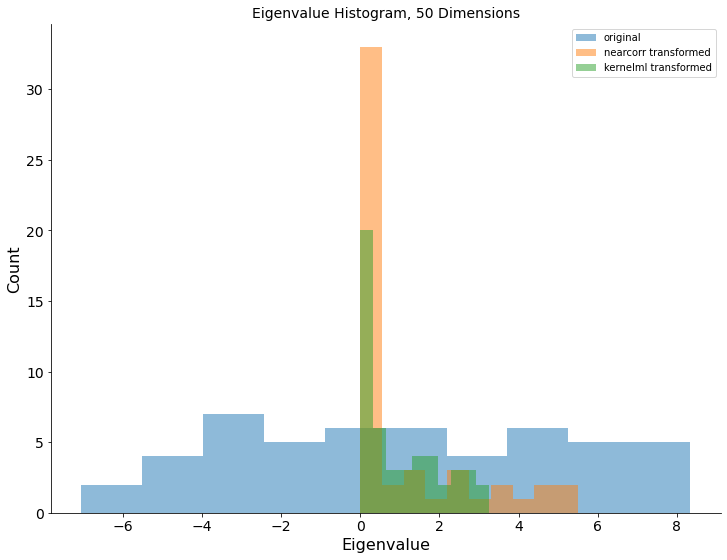

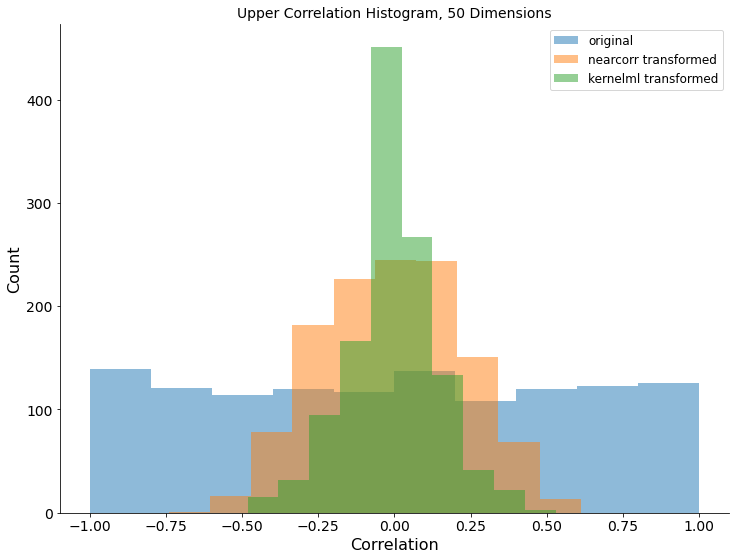

In [316]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(np.linalg.eigvals(V), alpha=0.5, label='original')
plt.hist(np.linalg.eigvals(nearcorr_newV), alpha=0.5, label='nearcorr transformed')
plt.hist(np.linalg.eigvals(kerneml_newV), alpha=0.5, label='kernelml transformed')
plt.title(f"Eigenvalue Histogram, 50 Dimensions", fontsize=14)
plt.xlabel("Eigenvalue", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(V[indices].flatten(), alpha=0.5, label='original')
plt.hist(nearcorr_newV[indices].flatten(), alpha=0.5, label='nearcorr transformed')
plt.hist(kernelml_newV[indices].flatten(), alpha=0.5, label='kernelml transformed')
plt.title(f"Upper Correlation Histogram, 50 Dimensions", fontsize=14)
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend( prop={'size': 12})
plt.show()

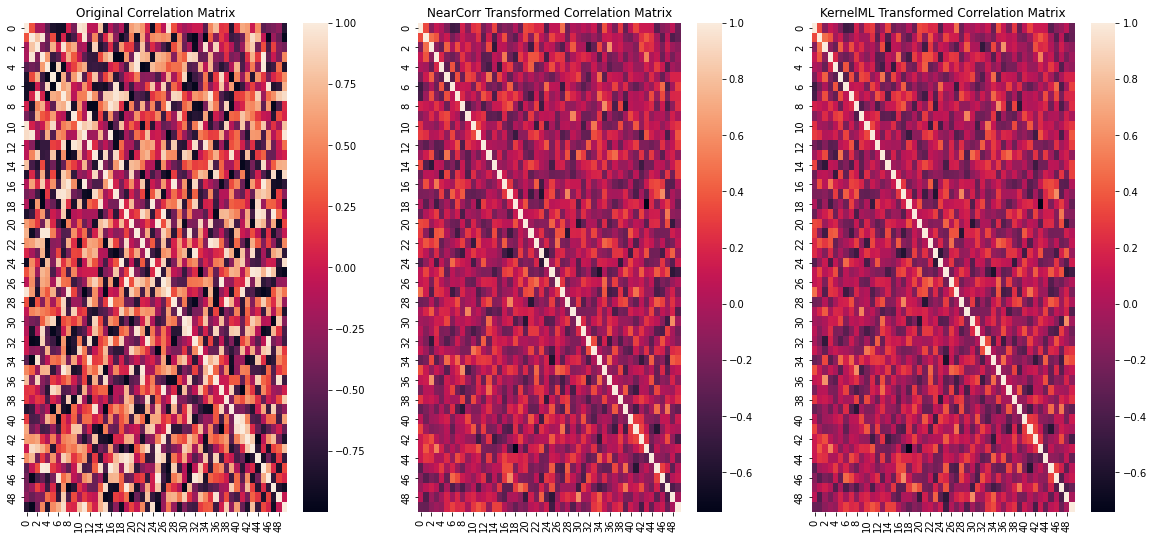

[[ 1.          1.          1.        ]
 [ 0.2805597   0.33918168 -0.04830046]
 [-0.17572409 -0.15057131  0.0024866 ]
 ...
 [-0.90674692 -0.27625461 -0.0032284 ]
 [-0.02587325 -0.01985898  0.04021127]
 [ 1.          1.          1.        ]]


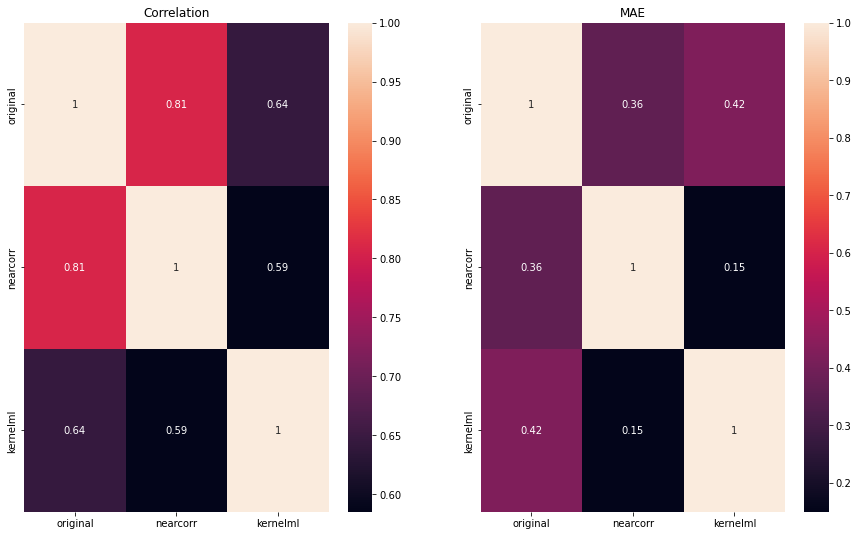

In [364]:
compare_corr_heatmaps(V, nearcorr_newV, kernelml_newV, annot=False)

In [372]:
max_5_var = np.argsort(np.var(kmldata0.update_by_realization,axis=0))[-5:]

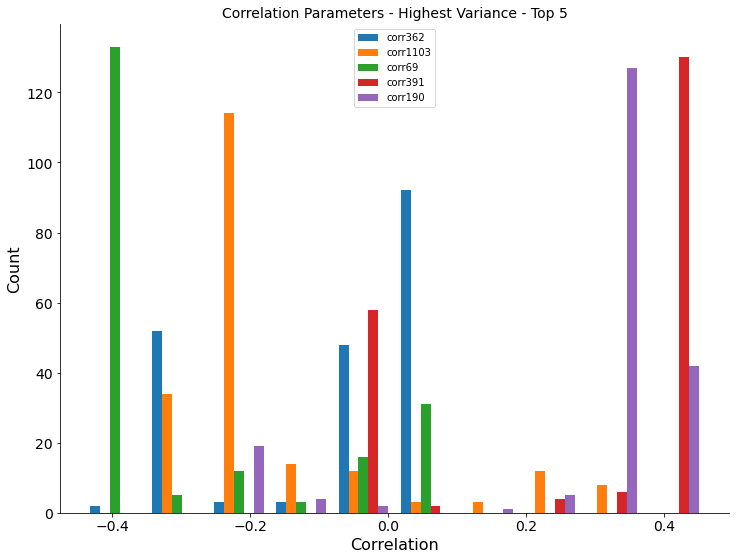

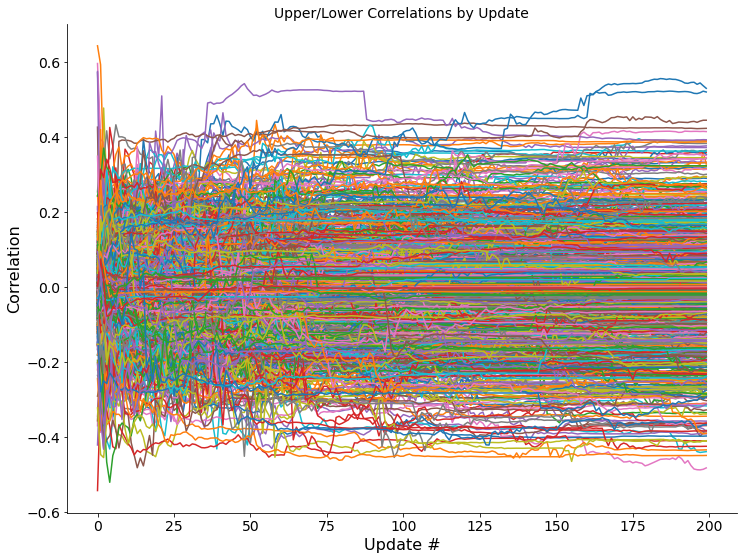

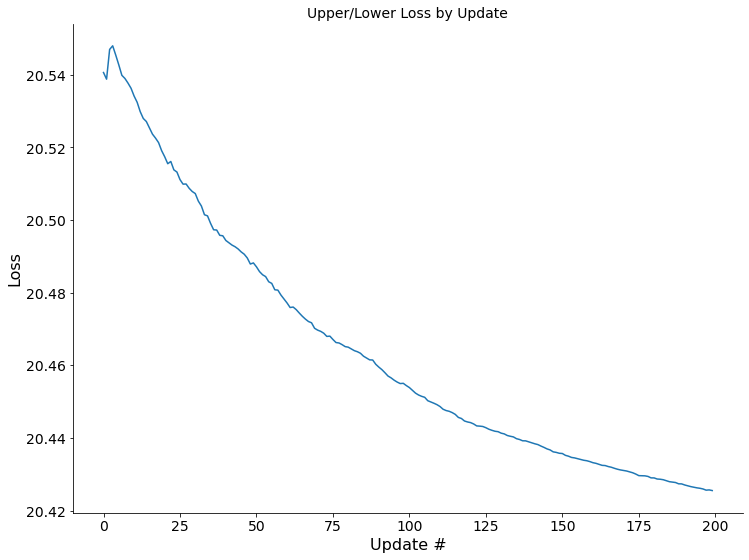

In [382]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

tmp = pd.DataFrame(kmldata0.update_by_realization[:, max_5_var])
tmp.columns = [f'corr{indx}' for indx in max_5_var]
plt.hist(tmp, label=[f'corr{indx}' for indx in max_5_var])
# tmp.hist()
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Correlation Parameters - Highest Variance - Top 5", fontsize=14)
plt.legend()
plt.show()


plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(kmldata0.update_by_realization[:])
plt.xlabel("Update #", fontsize=16)
plt.ylabel("Correlation", fontsize=16)
plt.title("Upper/Lower Correlations by Update", fontsize=14)
plt.show()

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(kmldata0.loss_by_realization[:])
plt.xlabel("Update #", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Upper/Lower Loss by Update", fontsize=14)
plt.show()

In [380]:
plt.hist?

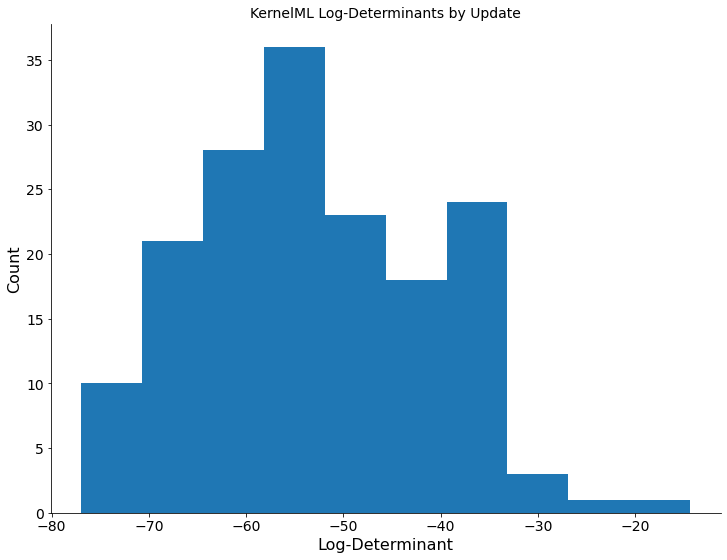

In [315]:
updatedVList = []
for w in kmldata0.update_by_realization:
    newV = V.copy()

    indices = np.tril_indices(V.shape[1],k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
    
    if is_psd(newV):
        updatedVList.append(newV)
    
logDeterminants = []
for v in updatedVList:
    logDeterminants.append(np.log(np.linalg.det(v)))
    
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(logDeterminants)
plt.xlabel("Log-Determinant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("KernelML Log-Determinants by Update", fontsize=14)
plt.show()


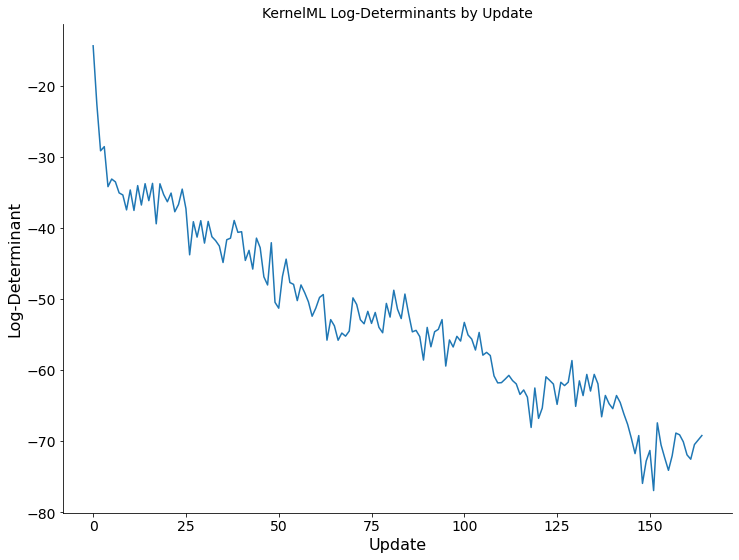

In [324]:
updatedVList = []
for w in kmldata0.update_by_realization:
    newV = V.copy()

    indices = np.tril_indices(V.shape[1],k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
    
    if is_psd(newV):
        updatedVList.append(newV)
    
logDeterminants = []
for v in updatedVList:
    logDeterminants.append(np.log(np.linalg.det(v)))
    
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(logDeterminants)
plt.xlabel("Update", fontsize=16)
plt.ylabel("Log-Determinant", fontsize=16)
plt.title("KernelML Log-Determinants by Update", fontsize=14)
plt.show()


In [297]:
eVa, eVe = np.linalg.eig(np.diag(np.ones(50)))
R, S = eVe, np.diag(np.sqrt(eVa))

In [296]:
eVa

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [304]:
eVa, eVe = np.linalg.eig(kernelml_newV)
R, S = eVe, np.diag(np.sqrt(eVa))

In [305]:
R[:,:3], S[:3]

(array([[ 0.0030472 , -0.14456383,  0.01538711],
        [ 0.06783273, -0.21065394, -0.12764992],
        [ 0.17569156,  0.03181605,  0.231697  ],
        [-0.16827817, -0.3105872 ,  0.09651462],
        [ 0.13413701, -0.05411354,  0.16988024],
        [-0.10794623,  0.02797787,  0.14292752],
        [-0.00890195,  0.18828484,  0.0141607 ],
        [-0.11467344,  0.08050679,  0.12248601],
        [-0.16939674,  0.05814349, -0.00994232],
        [-0.0591858 , -0.14891264,  0.2984884 ],
        [-0.10699333, -0.03608025,  0.23155646],
        [-0.271913  ,  0.14871813,  0.10145544],
        [ 0.02770599,  0.28432475, -0.1458868 ],
        [ 0.20080962,  0.10716365, -0.07269055],
        [-0.16633538, -0.12906352, -0.17121832],
        [-0.04995085, -0.0939521 , -0.19840635],
        [-0.00463176,  0.0091892 ,  0.13785345],
        [-0.06837408,  0.20791292, -0.06237954],
        [ 0.23668194, -0.17613903,  0.01888457],
        [ 0.15571902, -0.05102861,  0.18988418],
        [ 0.09097137

In [306]:
S.shape

(50, 50)

In [307]:
T = (S[:3, :]).dot(R[:3].T)

In [308]:
T

array([[ 0.00550274,  0.12249448,  0.31726935],
       [-0.25705896, -0.37457836,  0.05657432],
       [ 0.0259998 , -0.21569169,  0.39150138]])

In [309]:
resolution=10
u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
X_surface = np.cos(u)*np.sin(v)
Y_surface = np.sin(u)*np.sin(v)
Z_surface = np.cos(v)

In [310]:

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[],layout=layout)


fig.add_trace(go.Surface(x=X_surface, y=Y_surface, z=Z_surface, opacity=0.25, showlegend=False, showscale=False))

fig.show()

In [311]:
X_surfaceT, Y_surfaceT, Z_surfaceT = np.array_split(np.concatenate([
X_surface[:, :, np.newaxis],
Y_surface[:, :, np.newaxis],
Z_surface[:, :, np.newaxis]
], axis=-1).dot(T), 3, axis=-1)

X_surfaceT, Y_surfaceT, Z_surfaceT = X_surfaceT.squeeze(), Y_surfaceT.squeeze(), Z_surfaceT.squeeze()

In [312]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[],layout=layout)


fig.add_trace(go.Surface(x=X_surfaceT, y=Y_surfaceT, z=Z_surfaceT, opacity=0.25, showlegend=False, showscale=False))

fig.show()

In [291]:
T

array([[ 0.00550274,  0.12249448,  0.31726935],
       [-0.25705896, -0.37457836,  0.05657432],
       [ 0.0259998 , -0.21569169,  0.39150138]])